Epoch 0, Loss: 305.24570
Epoch 1000, Loss: 0.20904
Epoch 2000, Loss: 0.00717
Epoch 3000, Loss: 0.00270
Epoch 4000, Loss: 0.00141
Epoch 5000, Loss: 0.00090
Epoch 6000, Loss: 0.00074
Epoch 7000, Loss: 0.00071
Epoch 8000, Loss: 0.00050
Epoch 9000, Loss: 0.00042


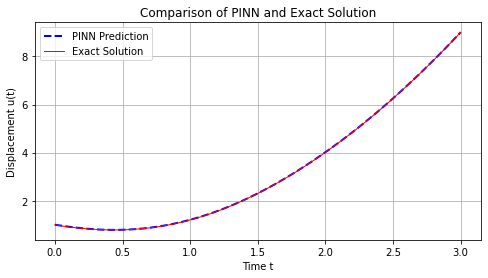

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the Physics-Informed Neural Network (PINN)
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20),    # Input layer (x) to hidden layer 1
            nn.Tanh(),
            nn.Linear(20, 20),   # Hidden layer 1 to hidden layer 2
            nn.Tanh(),
            nn.Linear(20, 20),   # Hidden layer 2 to hidden layer 3
            nn.Tanh(),
            nn.Linear(20, 1)     # Output layer (predicted y value)
        )
    
    def forward(self, x):
        return self.net(x)

# Compute the loss function (equation residual + initial condition)
def compute_loss(net, x_domain):
    x = x_domain.clone().requires_grad_(True)  # Enable gradient tracking
    y_pred = net(x)
    
    # Compute the first derivative of y
    y_prime = torch.autograd.grad(
        outputs=y_pred,
        inputs=x,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True
    )[0]
    
    # Compute coefficients in the differential equation
    denominator = 1 + x + x**3
    term = (1 + 3*x**2) / denominator
    P = x + term
    Q = x**3 + 2*x + x**2 * (1 + 3*x**2) / denominator
    
    # Equation residual: LHS - RHS
    residual = y_prime + P * y_pred - Q
    equation_loss = torch.mean(residual**2)  # Mean squared error of the residual
    
    # Initial condition (y(0) = 1)
    x_initial = torch.tensor([[0.0]], dtype=torch.float32)
    y_initial_pred = net(x_initial)
    initial_loss = (y_initial_pred - 1.0)**2  # Initial condition loss
    
    return equation_loss + initial_loss

# Training setup
net = PINN()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
epochs = 10000  # Number of training epochs
domain_range = [0.0, 3.0]  # Domain range

# Training loop
for epoch in range(epochs):
    # Randomly sample training points within the domain
    x_train = torch.rand(1000, 1) * (domain_range[1] - domain_range[0]) + domain_range[0]
    
    # Compute total loss and backpropagate
    optimizer.zero_grad()
    loss = compute_loss(net, x_train)
    loss.backward()
    optimizer.step()
    
    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.5f}')


x_test = torch.linspace(domain_range[0], domain_range[1], 1000).reshape(-1, 1)
y_pred = net(x_test).detach().numpy()

# Exact solution (given in the problem)
def exact_solution(x):
    return np.exp((-x**2)/2)/(1+x+x**3) + x**2

y_exact = exact_solution(x_test.numpy())

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
plt.figure(figsize=(8, 4))
plt.plot(x_test, y_pred, 'b--', linewidth=2, label='PINN Prediction')
plt.plot(x_test, y_exact, 'r-', linewidth=1, label='Exact Solution')
plt.xlabel('Time t')
plt.ylabel('Displacement u(t)')
plt.legend()
plt.title('Comparison of PINN and Exact Solution')
plt.grid(True)
plt.show()

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_exact = y_exact.reshape(-1, 1)
y_p_pinn = y_pred
y_true = y_exact
R2_pinn = r2_score(y_p_pinn, y_true)
mae_pinn = mean_absolute_error(y_p_pinn, y_true)
rmse_pinn = mean_squared_error(y_p_pinn, y_true, squared=False)
inf_norm_pinn = np.linalg.norm(y_p_pinn - y_true, ord = np.inf)

print(f"R2_pinn: {R2_pinn}, mae_pinn: {mae_pinn}, rmse_pinn: {rmse_pinn}, inf_norm_pinn: {inf_norm_pinn}")

R2_pinn: 0.9999958806147902, mae_pinn: 0.00445417407900095, rmse_pinn: 0.005049563944339752, inf_norm_pinn: 0.009906470775604248


In [3]:
import numpy as np
import pandas as pd

data_to_save = pd.DataFrame({
    'x': x_test.flatten(),
    'y_pred_pinn': y_p_pinn.flatten(),
    'y_exact': y_true.flatten()
})

# 保存为 CSV 文件
data_to_save.to_csv('pinn_01.csv', index=False)
print(" pinn_01.csv")

数据已保存至 pinn_01.csv
